In [2]:
import numpy as np
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline     
import sklearn
import pandas as pd
 
import tigramite
from tigramite import data_processing as pp
from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
from tigramite.independence_tests.parcorr import ParCorr
from tigramite.toymodels import structural_causal_processes as toys

# Notebook 2: Introduction to PC-MCI
On this tutorial a simple causal discovery example with 4 toy time-series will be implemented. First, PC-MCI two-steps will be simulated from scratch using sklearn and stats packages, in order to understand what the algorithm is doing under the hood. Then, the same experiment will be replicated using Tigramite. See Section 3.1.2 for more information.

## 1. Data generation and visualization

In [2]:
np.random.seed(42)     # Fix random seed
links_coeffs = {0: [((0, -1), 0.7), ((1, -1), -0.8)],
                1: [((1, -1), 0.8), ((3, -1), 0.8)],
                2: [((2, -1), 0.5), ((1, -2), 0.5), ((3, -3), 0.6)],
                3: [((3, -1), 0.4)],
                }
T = 1000     # time series length
data, _ = toys.var_process(links_coeffs, T=T)
print (data.shape)

# Initialize dataframe object, specify time axis and variable names
var_names = [r'$A$', r'$B$', r'$C$', r'$D$']
df = pp.DataFrame(data, datatime = np.arange(len(data)), var_names=var_names)

(1000, 4)


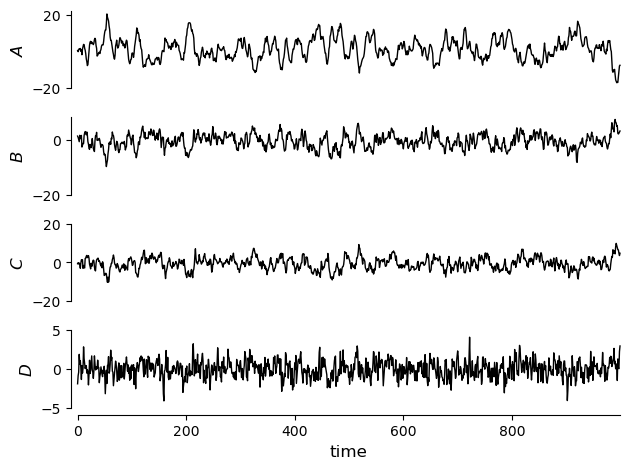

In [3]:
tp.plot_timeseries(df)
plt.show()

In [3]:
A = data[:,0]
B = data[:,1]
C = data[:,2]
D = data[:,3]

## 2. Python implementation of PCMCI with sklearn and scipy

In [4]:
# Define a function to compute the Pearson correlation coefficient and p-value for lagged cases
def lagged_correlation(x, y, max_lag):
    correlations = []
    p_values = []
    for lag in range(-max_lag, max_lag + 1):
        if lag < 0:  # y remains the same and x is lagged
            x_lagged = x[:lag]
            y_lagged = y[-lag:]
        elif lag > 0:  # x remains the same and y is lagged
            x_lagged = x[lag:]
            y_lagged = y[:-lag]
        else:
            x_lagged = x
            y_lagged = y

        correlation, p_value = pearsonr(x_lagged, y_lagged)
        correlations.append(correlation)
        p_values.append(p_value)

    return correlations, p_values

# Set the maximum lag you want to consider
max_lag = 4

In [4]:
def parcorr(x, y, cond, x_lag = None, y_lag = None,  cond_lag = None):
    """
        Partial correlations conditioning on a single variable
    """
    if x_lag:
        x_lagged = np.roll(x, shift=-x_lag)
    else:
        x_lagged = x

    if y_lag:
        y_lagged = np.roll(y, shift=-y_lag)
    else:
        y_lagged = y

    if cond_lag:
        cond = np.roll(cond, shift=-cond_lag)

    model = LinearRegression()
    cond = np.array(cond).reshape(-1, 1)
    
    model.fit(cond, x_lagged)
    predictions = model.predict(cond)
    residualsX = x_lagged - predictions

    model = LinearRegression()
    
    model.fit(cond, y_lagged)
    predictions = model.predict(cond)
    residualsY = y_lagged - predictions
    correlation_coefficient, p_value = pearsonr(residualsX, residualsY)

    return correlation_coefficient, p_value

In [5]:
def parcorr2(x, y, cond, cond2, x_lag = None, y_lag = None,  cond_lag = None, cond_lag2 = None):
    '''
        Partial correlations conditioning on 2 variables
    '''
    if x_lag:
        x_lagged = np.roll(x, shift=-x_lag)
    else:
        x_lagged = x

    if y_lag:
        y_lagged = np.roll(y, shift=-y_lag)
    else:
        y_lagged = y

    if cond_lag:
        cond = np.roll(cond, shift=-cond_lag)

    if cond_lag2:
        cond2 = np.roll(cond2, shift=-cond_lag2)

    model = LinearRegression()
    df = pd.DataFrame({'x':cond, 'y':cond2})
    
    model.fit(df, x_lagged)
    predictions = model.predict(df)
    residualsX = x_lagged - predictions

    model = LinearRegression()
    
    model.fit(df, y_lagged)
    predictions = model.predict(df)
    residualsY = y_lagged - predictions
    correlation_coefficient, p_value = pearsonr(residualsX, residualsY)

    return correlation_coefficient, p_value

In [6]:
def parcorr3(x, y, cond, cond2, cond3, x_lag = None, y_lag = None,  cond_lag = None, cond_lag2 = None, cond_lag3 = None):
    '''
        Partial correlations conditioning on 3 variables
    '''
    if x_lag:
        x_lagged = np.roll(x, shift=-x_lag)
    else:
        x_lagged = x

    if y_lag:
        y_lagged = np.roll(y, shift=-y_lag)
    else:
        y_lagged = y

    if cond_lag:
        cond = np.roll(cond, shift=-cond_lag)

    if cond_lag2:
        cond2 = np.roll(cond2, shift=-cond_lag2)

    if cond_lag3:
        cond3 = np.roll(cond3, shift=-cond_lag3)

    model = LinearRegression()
    df = pd.DataFrame({'x': cond, 'y': cond2, 'z': cond3})
    
    model.fit(df, x_lagged)
    predictions = model.predict(df)
    residualsX = x_lagged - predictions

    model = LinearRegression()
    
    model.fit(df, y_lagged)
    predictions = model.predict(df)
    residualsY = y_lagged - predictions
    correlation_coefficient, p_value = pearsonr(residualsX, residualsY)

    return correlation_coefficient, p_value

In [7]:
# Compute the Pearson correlation coefficients and p-values for lagged cases
correlations, p_values = lagged_correlation(D, D, max_lag)

# Print the results
for lag, correlation, p_value in zip(range(-max_lag, max_lag + 1), correlations, p_values):
    print(f"At lag {lag}: Pearson correlation coefficient = {correlation}, p-value = {p_value}")

At lag -4: Pearson correlation coefficient = -0.006462482104851624, p-value = 0.8385891068694858
At lag -3: Pearson correlation coefficient = 0.04385014514081114, p-value = 0.16650843787007297
At lag -2: Pearson correlation coefficient = 0.14924775858176725, p-value = 2.1846803488918197e-06
At lag -1: Pearson correlation coefficient = 0.3968439766670343, p-value = 5.034847291110035e-39
At lag 0: Pearson correlation coefficient = 0.9999999999999993, p-value = 0.0
At lag 1: Pearson correlation coefficient = 0.3968439766670343, p-value = 5.034847291110035e-39
At lag 2: Pearson correlation coefficient = 0.14924775858176725, p-value = 2.1846803488918197e-06
At lag 3: Pearson correlation coefficient = 0.04385014514081114, p-value = 0.16650843787007297
At lag 4: Pearson correlation coefficient = -0.006462482104851624, p-value = 0.8385891068694858


In [35]:
# Compute the Pearson correlation coefficients and p-values for lagged cases
correlations, p_values = lagged_correlation(B, D, max_lag)

# Print the results
for lag, correlation, p_value in zip(range(-max_lag, max_lag + 1), correlations, p_values):
    print(f"At lag {lag}: Pearson correlation coefficient = {correlation}, p-value = {p_value}")

At lag -4: Pearson correlation coefficient = -0.01080126900500747, p-value = 0.7335070009421222
At lag -3: Pearson correlation coefficient = -0.023226447317678218, p-value = 0.46382622195864814
At lag -2: Pearson correlation coefficient = -0.028577059291962637, p-value = 0.36714473019017835
At lag -1: Pearson correlation coefficient = 0.014275470947128721, p-value = 0.6522329395215424
At lag 0: Pearson correlation coefficient = 0.14131409797813296, p-value = 7.2680684799667005e-06
At lag 1: Pearson correlation coefficient = 0.48456804273814763, p-value = 5.967479183150924e-60
At lag 2: Pearson correlation coefficient = 0.5248252308320601, p-value = 9.956884334261208e-72
At lag 3: Pearson correlation coefficient = 0.45633634650008814, p-value = 1.9566249052164953e-52
At lag 4: Pearson correlation coefficient = 0.3793402029252322, p-value = 1.934113626253346e-35


In [36]:
# Compute the Pearson correlation coefficients and p-values for lagged cases
correlations, p_values = lagged_correlation(C, D, max_lag)

# Print the results
for lag, correlation, p_value in zip(range(-max_lag, max_lag + 1), correlations, p_values):
    print(f"At lag {lag}: Pearson correlation coefficient = {correlation}, p-value = {p_value}")

At lag -4: Pearson correlation coefficient = -0.016067892674269516, p-value = 0.6125126696871611
At lag -3: Pearson correlation coefficient = -0.008740649183267635, p-value = 0.7828186527237398
At lag -2: Pearson correlation coefficient = -0.0025628395168861007, p-value = 0.9355519514314868
At lag -1: Pearson correlation coefficient = -0.01850856623386834, p-value = 0.5590069330821335
At lag 0: Pearson correlation coefficient = -0.008450281712787066, p-value = 0.7895523804006135
At lag 1: Pearson correlation coefficient = 0.04574939608431852, p-value = 0.14847315681993098
At lag 2: Pearson correlation coefficient = 0.16595143333741338, p-value = 1.3448590833000897e-07
At lag 3: Pearson correlation coefficient = 0.5052729674926963, p-value = 1.020073582511079e-65
At lag 4: Pearson correlation coefficient = 0.5482029693489252, p-value = 3.2696976524494385e-79


In [37]:
# Compute the Pearson correlation coefficients and p-values for lagged cases
correlations, p_values = lagged_correlation(A, D, max_lag)

# Print the results
for lag, correlation, p_value in zip(range(-max_lag, max_lag + 1), correlations, p_values):
    print(f"At lag {lag}: Pearson correlation coefficient = {correlation}, p-value = {p_value}")

At lag -4: Pearson correlation coefficient = 0.026853256344573924, p-value = 0.3972387880769623
At lag -3: Pearson correlation coefficient = 0.027140810251718293, p-value = 0.3919634647590069
At lag -2: Pearson correlation coefficient = 0.03111078765966986, p-value = 0.32618304241830026
At lag -1: Pearson correlation coefficient = 0.03495321626358348, p-value = 0.2697150177617114
At lag 0: Pearson correlation coefficient = 0.018134411357344227, p-value = 0.5667866869484142
At lag 1: Pearson correlation coefficient = -0.04271677476625078, p-value = 0.17731355227098228
At lag 2: Pearson correlation coefficient = -0.19786263884162933, p-value = 2.876175207163496e-10
At lag 3: Pearson correlation coefficient = -0.33420529626597417, p-value = 1.9301842622180253e-27
At lag 4: Pearson correlation coefficient = -0.40526304074739994, p-value = 1.170140028350057e-40


On the first iteration of the algorithm, we check correlations conditioning on the empty set. On this step we already see that all correlations from any lagged variable with D is not significative except for $D_{t-1}$ and $D_{t-2}$, with a 0.05 significance level. Therefore, we can reduce the set of possible parents of D to P($D_t$) = {$D_{t-1}, D_{t-2}$}, being $D_{t-1}$ the lagged variable with strongest correlation. Thus, in the next iteration we only need to compute the partial correlations between $D_t$ and $D_{t-2}$, conditioning on $D_{t-1}$

In [8]:
rho, p_value = parcorr(D, D, D, x_lag=-2,y_lag=None,cond_lag=-1)
print(rho)
print(p_value)

-0.01134031827919337
0.7202120967295486


We find that $D_t$ and $D_{t-2}$ are independent conditioning on $D_{t-1}$. Therefore, P($D_t$) = {$D_{t-1}$}. We continue checking correlations for all pairs of variables:

In [7]:
# Compute the Pearson correlation coefficients and p-values for lagged cases
correlations, p_values = lagged_correlation(A, B, max_lag)

# Print the results
for lag, correlation, p_value in zip(range(-max_lag, max_lag + 1), correlations, p_values):
    print(f"At lag {lag}: Pearson correlation coefficient = {correlation}, p-value = {p_value}")

At lag -4: Pearson correlation coefficient = -0.26329308454626565, p-value = 2.9516526084891295e-17
At lag -3: Pearson correlation coefficient = -0.3387534099849575, p-value = 3.4205467194767537e-28
At lag -2: Pearson correlation coefficient = -0.43084277153024786, p-value = 2.2747330586966255e-46
At lag -1: Pearson correlation coefficient = -0.553668020897425, p-value = 2.5400808921891503e-81
At lag 0: Pearson correlation coefficient = -0.6994172542604358, p-value = 9.568604078280491e-148
At lag 1: Pearson correlation coefficient = -0.8515144634413605, p-value = 8.297376423208423e-282
At lag 2: Pearson correlation coefficient = -0.8993836242869606, p-value = 0.0
At lag 3: Pearson correlation coefficient = -0.8696469549368772, p-value = 2.7329259170225733e-307
At lag 4: Pearson correlation coefficient = -0.7914861042467791, p-value = 9.154034864051097e-215


In [8]:
# Compute the Pearson correlation coefficients and p-values for lagged cases
correlations, p_values = lagged_correlation(A, C, max_lag)

# Print the results
for lag, correlation, p_value in zip(range(-max_lag, max_lag + 1), correlations, p_values):
    print(f"At lag {lag}: Pearson correlation coefficient = {correlation}, p-value = {p_value}")

At lag -4: Pearson correlation coefficient = -0.43794848454318214, p-value = 6.267050101200411e-48
At lag -3: Pearson correlation coefficient = -0.5552703715838542, p-value = 1.0201624822905751e-81
At lag -2: Pearson correlation coefficient = -0.6899980685002991, p-value = 5.625728260925132e-142
At lag -1: Pearson correlation coefficient = -0.8105871032298342, p-value = 6.384076786302013e-234
At lag 0: Pearson correlation coefficient = -0.8501442445039177, p-value = 2.9460233809741786e-280
At lag 1: Pearson correlation coefficient = -0.8285281113811125, p-value = 2.436814707741708e-253
At lag 2: Pearson correlation coefficient = -0.7654164906247964, p-value = 7.186810605191677e-193
At lag 3: Pearson correlation coefficient = -0.6814539645046085, p-value = 4.736220215295468e-137
At lag 4: Pearson correlation coefficient = -0.5895893608032291, p-value = 2.7544937015662194e-94


In [9]:
# Compute the Pearson correlation coefficients and p-values for lagged cases
correlations, p_values = lagged_correlation(A, A, max_lag)

# Print the results
for lag, correlation, p_value in zip(range(-max_lag, max_lag + 1), correlations, p_values):
    print(f"At lag {lag}: Pearson correlation coefficient = {correlation}, p-value = {p_value}")

At lag -4: Pearson correlation coefficient = 0.639562357105653, p-value = 1.150780887042567e-115
At lag -3: Pearson correlation coefficient = 0.7489404012043539, p-value = 4.98508498045309e-180
At lag -2: Pearson correlation coefficient = 0.8587359967336421, p-value = 1.7980346699911667e-291
At lag -1: Pearson correlation coefficient = 0.9483680930739735, p-value = 0.0
At lag 0: Pearson correlation coefficient = 1.0, p-value = 0.0
At lag 1: Pearson correlation coefficient = 0.9483680930739735, p-value = 0.0
At lag 2: Pearson correlation coefficient = 0.8587359967336421, p-value = 1.7980346699911667e-291
At lag 3: Pearson correlation coefficient = 0.7489404012043539, p-value = 4.98508498045309e-180
At lag 4: Pearson correlation coefficient = 0.639562357105653, p-value = 1.150780887042567e-115


In [ ]:
# Compute the Pearson correlation coefficients and p-values for lagged cases
correlations, p_values = lagged_correlation(A, C, max_lag)

# Print the results
for lag, correlation, p_value in zip(range(-max_lag, max_lag + 1), correlations, p_values):
    print(f"At lag {lag}: Pearson correlation coefficient = {correlation}, p-value = {p_value}")

In [35]:
rho, p_value = parcorr(A, A, B, x_lag=-1,y_lag=None,cond_lag=-2)
print(rho)
print(p_value)

0.793350491811774
2.4178098288011733e-217


In [33]:
variables = {'A': A, 'B': B, 'C': C, 'D': D}
var_names = []
lags = []
rhos = []
p = []


for var_name, var_value in variables.items():
    for lag in [-1,-2,-3,-4]:
        rho, p_value = parcorr(var_value, A, A, x_lag=lag,y_lag=None,cond_lag=-1)
        var_names.append(var_name)
        lags.append(lag)
        rhos.append(rho)
        p.append(p_value)

df = pd.DataFrame({'var': var_names, 'lag':lags, 'rho':rhos, 'p-value' : p})



,var,lag,rho,p-value
0,A,-1,0.004365,8.903405e-01
1,A,-2,-0.395626,8.202662e-39
2,A,-3,-0.400039,1.012200e-39
3,A,-4,-0.336439,6.904867e-28
4,B,-1,-0.822996,2.301545e-247
5,B,-2,-0.547793,2.200548e-79
6,B,-3,-0.121331,1.199486e-04
7,B,-4,0.207096,3.777067e-11
8,C,-1,-0.131113,3.197320e-05
9,C,-2,0.110557,4.609521e-04


In [38]:
df = df.drop(0)
new_row = {'var': 'A', 'lag': -1, 'rho': 0.793350491811774, 'p-value': 2.4178098288011733e-217}


df = df.append(new_row, ignore_index=True)

df = df.loc[df['rho'].abs().sort_values(ascending=False).index]
df

,var,lag,rho,p-value
3,B,-1,-0.822996,2.301545e-247
15,A,-1,0.793350,2.417810e-217
4,B,-2,-0.547793,2.200548e-79
12,D,-2,-0.491354,6.725546e-62
13,D,-3,-0.465059,8.307901e-55
1,A,-3,-0.400039,1.012200e-39
0,A,-2,-0.395626,8.202662e-39
2,A,-4,-0.336439,6.904867e-28
14,D,-4,-0.290143,7.543493e-21
10,C,-4,0.243926,5.181936e-15


We studied partial correlations on all possible parents conditioning on the strongest correlation. All possible parents remained dependent. Therefore, we go to the next step, conditioning on the two strongest parents, being now $B_{t-1}$ and $A_{t-1}$:

In [39]:
var_names = []
lags = []
rhos = []
p = []


for var_name, var_value in variables.items():
    for lag in [-1,-2,-3,-4]:
        rho, p_value = parcorr2(var_value, A, A, B, x_lag=lag,y_lag=None,cond_lag=-1, cond_lag2=-1)
        var_names.append(var_name)
        lags.append(lag)
        rhos.append(rho)
        p.append(p_value)

df = pd.DataFrame({'var': var_names, 'lag':lags, 'rho':rhos, 'p-value' : p})

In [40]:
df

,var,lag,rho,p-value
0,A,-1,0.006441,0.838798
1,A,-2,0.000133,0.996655
2,A,-3,-0.000635,0.984003
3,A,-4,-0.003149,0.920764
4,B,-1,0.003311,0.916722
5,B,-2,-0.012499,0.693017
6,B,-3,-0.007900,0.802970
7,B,-4,-0.006149,0.846010
8,C,-1,0.000248,0.993743
9,C,-2,-0.002834,0.928678


Conditioning on two variables all remaining possible parents are conditionally independent with a 0.05 confidence level. Thus, the remaining set of possible parents is P($A_t$) = {$B_{t-1}$, $A_{t-1}$}. The next step would be to condition on three variables. However, the number of conditions is bigger than the number of conditions so the algorithm $PC_1$ converges for A.

In [10]:
# Compute the Pearson correlation coefficients and p-values for lagged cases
correlations, p_values = lagged_correlation(C, C, max_lag)

# Print the results
for lag, correlation, p_value in zip(range(-max_lag, max_lag + 1), correlations, p_values):
    print(f"At lag {lag}: Pearson correlation coefficient = {correlation}, p-value = {p_value}")

At lag -4: Pearson correlation coefficient = 0.43334053030392505, p-value = 7.433510042055044e-47
At lag -3: Pearson correlation coefficient = 0.5450718491452617, p-value = 3.118589198897658e-78
At lag -2: Pearson correlation coefficient = 0.6761454160604005, p-value = 2.714524375729431e-134
At lag -1: Pearson correlation coefficient = 0.8404546705576776, p-value = 1.5159511660513824e-267
At lag 0: Pearson correlation coefficient = 1.0, p-value = 0.0
At lag 1: Pearson correlation coefficient = 0.8404546705576776, p-value = 1.5159511660513824e-267
At lag 2: Pearson correlation coefficient = 0.6761454160604005, p-value = 2.714524375729431e-134
At lag 3: Pearson correlation coefficient = 0.5450718491452617, p-value = 3.118589198897658e-78
At lag 4: Pearson correlation coefficient = 0.43334053030392505, p-value = 7.433510042055044e-47


In [8]:
variables = {'A': A, 'B': B, 'C': C, 'D': D}
var_names = []
lags = []
rhos = []
p = []


for var_name, var_value in variables.items():
    for lag in [-1,-2,-3,-4]:
        rho, p_value = parcorr(var_value, B, B, x_lag=lag,y_lag=None,cond_lag=-1)
        var_names.append(var_name)
        lags.append(lag)
        rhos.append(rho)
        p.append(p_value)

df = pd.DataFrame({'var': var_names, 'lag':lags, 'rho':rhos, 'p-value' : p})

Conditioning on the strongest parent $B_{t-1}$ the set of possible parents of $B_t$ is reduced to 7 candidates:

In [10]:
df = df.drop(4)
new_row = {'var': 'B', 'lag': -1, 'rho': 0.6932558060957481, 'p-value': 3.9343024462729703e-144}


df = df.append(new_row, ignore_index=True)

df = df.loc[df['rho'].abs().sort_values(ascending=False).index]
df

C:\Users\Usuario\AppData\Local\Temp\ipykernel_17288\2089049306.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)


,var,lag,rho,p-value
15,B,-1,0.693256,3.934302e-144
11,D,-1,0.685583,9.321762e-140
12,D,-2,0.246708,2.483049e-15
4,B,-2,-0.131761,2.919162e-05
5,B,-3,-0.095337,2.545156e-03
0,A,-1,0.091695,3.706393e-03
1,A,-2,0.078391,1.315059e-02
2,A,-3,0.049215,1.198714e-01
6,B,-4,-0.043828,1.660811e-01
3,A,-4,0.043327,1.709841e-01


In [11]:
selected_data = df.loc[df['p-value'] < 0.05, ['var', 'lag']]
selected_data

,var,lag
15,B,-1
11,D,-1
12,D,-2
4,B,-2
5,B,-3
0,A,-1
1,A,-2


In [24]:
var_names = []
lags = []
rhos = []
p = []

for index, row in selected_data.iterrows():
    rho, p_value = parcorr2(globals()[row['var']], B, B, D, x_lag=row['lag'],y_lag=None,cond_lag=-1, cond_lag2=-1)
    var_names.append(row['var'])
    lags.append(row['lag'])
    rhos.append(rho)
    p.append(p_value)


df = pd.DataFrame({'var': var_names, 'lag':lags, 'rho':rhos, 'p-value' : p})
df
    

B
D
D
B
B
A
A


,var,lag,rho,p-value
0,B,-1,0.009749,0.758153
1,D,-1,0.001196,0.969878
2,D,-2,0.000238,0.994001
3,B,-2,0.006115,0.846850
4,B,-3,-0.005503,0.862019
5,A,-1,0.007953,0.801677
6,A,-2,0.003797,0.904557


Finally, conditioning on the two strongest parents on the previous iteration, all remaining test results are not significant. Therefore, they are conditionally independent and the algorithm converges. The set of possible parents is reduced to P($B_t$) = {$B_{t-1}$, $D_{t-1}$}. Finally we search for the parents of $C_t$:

In [9]:
variables = {'A': A, 'B': B, 'C': C, 'D': D}
var_names = []
lags = []
rhos = []
p = []


for var_name, var_value in variables.items():
    for lag in [-1,-2,-3,-4]:
        rho, p_value = parcorr(var_value, C, B, x_lag=lag,y_lag=None,cond_lag=-2)
        var_names.append(var_name)
        lags.append(lag)
        rhos.append(rho)
        p.append(p_value)

df = pd.DataFrame({'var': var_names, 'lag':lags, 'rho':rhos, 'p-value' : p})
df


c:\Users\Usuario\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


,var,lag,rho,p-value
0,A,-1,-0.186349,2.892610e-09
1,A,-2,-0.186875,2.606505e-09
2,A,-3,-0.147640,2.750102e-06
3,A,-4,-0.116563,2.207358e-04
4,B,-1,0.077595,1.411182e-02
5,B,-2,NaN,NaN
6,B,-3,0.253684,3.768955e-16
7,B,-4,0.223225,9.301781e-13
8,C,-1,0.507073,1.920410e-66
9,C,-2,0.287436,1.783297e-20


In [22]:
parcorr(B, C, C, x_lag=-2,y_lag=None,cond_lag=-1)

(0.7286293069958393, 3.1660616228849854e-166)

In [10]:
df = df.drop(5)
df = df.drop(12)
new_row = {'var': 'B', 'lag': -2, 'rho': 0.7286293069958393, 'p-value': 3.1660616228849854e-166}


df = df.append(new_row, ignore_index=True)

df = df.loc[df['rho'].abs().sort_values(ascending=False).index]
df

C:\Users\Usuario\AppData\Local\Temp\ipykernel_19380\2882229882.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)


,var,lag,rho,p-value
14,B,-2,0.728629,3.166062e-166
7,C,-1,0.507073,1.920410e-66
8,C,-2,0.287436,1.783297e-20
5,B,-3,0.253684,3.768955e-16
6,B,-4,0.223225,9.301781e-13
13,D,-4,0.196156,3.946575e-10
9,C,-3,0.190342,1.301996e-09
1,A,-2,-0.186875,2.606505e-09
0,A,-1,-0.186349,2.892610e-09
12,D,-3,0.173253,3.514727e-08


Conditioning on a single variable all possible relations remain significative. Therefore, we condition now on the two strongest parents:

In [11]:
selected_data = df.loc[df['p-value'] < 0.05, ['var', 'lag']]

var_names = []
lags = []
rhos = []
p = []

for index, row in selected_data.iterrows():
    rho, p_value = parcorr2(globals()[row['var']], C, B, C, x_lag=row['lag'],y_lag=None,cond_lag=-2, cond_lag2=-1)
    var_names.append(row['var'])
    lags.append(row['lag'])
    rhos.append(rho)
    p.append(p_value)


df = pd.DataFrame({'var': var_names, 'lag':lags, 'rho':rhos, 'p-value' : p})
df

,var,lag,rho,p-value
0,B,-2,0.000652,9.835808e-01
1,C,-1,-0.038201,2.274561e-01
2,C,-2,-0.114217,2.955290e-04
3,B,-3,-0.195372,4.645664e-10
4,B,-4,-0.149823,1.947650e-06
5,D,-4,0.125643,6.775822e-05
6,C,-3,-0.083646,8.133800e-03
7,A,-2,0.162413,2.419224e-07
8,A,-1,0.145264,3.980428e-06
9,D,-3,0.463220,2.470808e-54


In [12]:
df = df.drop(1)
df = df.drop(0)
new_row = {'var': 'B', 'lag': -2, 'rho': 0.7296448755118862, 'p-value': 6.526156354687527e-167}
new_row2 = {'var': 'C', 'lag': -1, 'rho': 0.4480888740589162, 'p-value': 1.5090670333598902e-50}


df = df.append(new_row, ignore_index=True)
df = df.append(new_row2, ignore_index=True)

df = df.loc[df['rho'].abs().sort_values(ascending=False).index]
df

C:\Users\Usuario\AppData\Local\Temp\ipykernel_19380\841936452.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)
C:\Users\Usuario\AppData\Local\Temp\ipykernel_19380\841936452.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row2, ignore_index=True)


,var,lag,rho,p-value
13,B,-2,0.729645,6.526156e-167
7,D,-3,0.463220,2.470808e-54
14,C,-1,0.448089,1.509067e-50
1,B,-3,-0.195372,4.645664e-10
11,D,-2,0.164589,1.659024e-07
5,A,-2,0.162413,2.419224e-07
2,B,-4,-0.149823,1.947650e-06
6,A,-1,0.145264,3.980428e-06
8,A,-3,0.135896,1.617527e-05
3,D,-4,0.125643,6.775822e-05


In [40]:
parcorr2(C, C, B, C, x_lag=-1,y_lag=None,cond_lag=-2, cond_lag2=-2)

(0.4480888740589162, 1.5090670333598902e-50)

In [13]:
selected_data = df.loc[df['p-value'] < 0.05, ['var', 'lag']]

var_names = []
lags = []
rhos = []
p = []

for index, row in selected_data.iterrows():
    rho, p_value = parcorr3(globals()[row['var']], C, B, C, D, x_lag=row['lag'],y_lag=None,cond_lag=-2, cond_lag2=-1, cond_lag3=-3)
    var_names.append(row['var'])
    lags.append(row['lag'])
    rhos.append(rho)
    p.append(p_value)


df = pd.DataFrame({'var': var_names, 'lag':lags, 'rho':rhos, 'p-value' : p})
df

,var,lag,rho,p-value
0,B,-2,-0.016048,0.612242
1,D,-3,-0.002104,0.947014
2,C,-1,-0.000442,0.988872
3,B,-3,0.018126,0.566967
4,D,-2,-0.003481,0.912464
5,A,-2,0.011236,0.722689
6,B,-4,0.006828,0.829257
7,A,-1,-0.007029,0.824321
8,A,-3,0.021262,0.501834
9,D,-4,-0.002651,0.933273


In [17]:
parcorr3(D, C, C, B, B, x_lag=-3,y_lag=None,cond_lag=-1, cond_lag2=-2, cond_lag3=-3)

(0.42856854057223354, 6.152977407143733e-46)

In [18]:
df = df.drop(2)
df = df.drop(1)
df = df.drop(0)
new_row = {'var': 'B', 'lag': -2, 'rho': 0.45315150340887494, 'p-value': 8.573120949103319e-52}
new_row2 = {'var': 'C', 'lag': -1, 'rho': 0.4829766273984322, 'p-value': 1.4273179712918688e-59}
new_row3 = {'var': 'D', 'lag': -3, 'rho': 0.42856854057223354, 'p-value': 6.152977407143733e-46}

df = df.append(new_row, ignore_index=True)
df = df.append(new_row2, ignore_index=True)
df = df.append(new_row3, ignore_index=True)

df = df.loc[df['rho'].abs().sort_values(ascending=False).index]
df

C:\Users\Usuario\AppData\Local\Temp\ipykernel_19380\514013002.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)
C:\Users\Usuario\AppData\Local\Temp\ipykernel_19380\514013002.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row2, ignore_index=True)
C:\Users\Usuario\AppData\Local\Temp\ipykernel_19380\514013002.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row3, ignore_index=True)


,var,lag,rho,p-value
13,C,-1,0.482977,1.427318e-59
12,B,-2,0.453152,8.573121e-52
14,D,-3,0.428569,6.152977e-46
7,C,-2,-0.029149,3.571481e-01
5,A,-3,0.021262,5.018339e-01
0,B,-3,0.018126,5.669666e-01
10,C,-4,-0.011754,7.104596e-01
2,A,-2,0.011236,7.226887e-01
11,C,-3,0.010816,7.326473e-01
9,A,-4,0.008744,7.824081e-01


The set of possible parents is reduced to 3 candidates:

In [19]:
selected_data = df.loc[df['p-value'] < 0.05, ['var', 'lag']]
selected_data

,var,lag
13,C,-1
12,B,-2
14,D,-3


Step one of the algorithm $PC_1$ is finished. Now step two (MCI) tests independence between variable and its parents, conditioning on the parents of its parents. We start with $D_t$:

In [20]:
parcorr(D, D, D, x_lag=-1,y_lag=None,cond_lag=-2)

(0.3672385044022585, 2.7520287727818208e-33)

In the case of $B_t$:


In [7]:
parcorr2(B, B, B, D, x_lag=-1,y_lag=None,cond_lag=-2, cond_lag2=-2)

(0.49430192704381853, 9.850055640195575e-63)

In [8]:
parcorr(D, B, D, x_lag=-1,y_lag=None,cond_lag=-2)

(0.3570544255112732, 1.9569306964427273e-31)

In the case of $A_t$:

In [9]:
parcorr2(A, A, A, B, x_lag=-1,y_lag=None,cond_lag=-2, cond_lag2=-2)

(0.46245393642315424, 3.882026063159389e-54)

In [10]:
parcorr2(B, A, D, B, x_lag=-1,y_lag=None,cond_lag=-2, cond_lag2=-2)

(-0.39778015176609827, 2.9656206301597016e-39)

Finally, in the case of $C_t$:

In [11]:
parcorr2(B, C, D, B, x_lag=-2,y_lag=None,cond_lag=-3, cond_lag2=-3)

(0.40992702260649555, 8.28921103877054e-42)

In [12]:
parcorr(D, C, D, x_lag=-3,y_lag=None,cond_lag=-4)

(0.3753672833195645, 8.182119458064007e-35)

In [13]:
parcorr3(C, C, C, B, D, x_lag=-1,y_lag=None,cond_lag=-2, cond_lag2=-3, cond_lag3=-4)

(0.2937629344075391, 2.3528101977204083e-21)

All possible parents have passed the MCI test. Thus the algorithm has been able to find the causal drivers of our dataset. 

## 3. Tigramite implementation of PCMCI
We will use now the tools already implemented in tigramite for the same analysis:

In [4]:
import time

start_time = time.time()
parcorr = ParCorr(significance='analytic')
pcmci = PCMCI(
    dataframe=df, 
    cond_ind_test=parcorr,
    verbosity=1)

results = pcmci.run_pcmci(tau_max=4, pc_alpha=0.05)
end_time = time.time()
execution_time = end_time - start_time
print("Execution time:", execution_time, "seconds")


##
## Step 1: PC1 algorithm with lagged conditions
##

Parameters:
independence test = par_corr
tau_min = 1
tau_max = 4
pc_alpha = [0.05]
max_conds_dim = None
max_combinations = 1



## Resulting lagged parent (super)sets:

    Variable $A$ has 3 link(s):
        ($A$ -1): max_pval = 0.00000, min_val =  0.796
        ($B$ -1): max_pval = 0.00000, min_val = -0.749
        ($C$ -4): max_pval = 0.04923, min_val =  0.063

    Variable $B$ has 2 link(s):
        ($B$ -1): max_pval = 0.00000, min_val =  0.694
        ($D$ -1): max_pval = 0.00000, min_val =  0.486

    Variable $C$ has 3 link(s):
        ($B$ -2): max_pval = 0.00000, min_val =  0.450
        ($C$ -1): max_pval = 0.00000, min_val =  0.445
        ($D$ -3): max_pval = 0.00000, min_val =  0.182

    Variable $D$ has 1 link(s):
        ($D$ -1): max_pval = 0.00000, min_val =  0.372

##
## Step 2: MCI algorithm
##

Parameters:

independence test = par_corr
tau_min = 0
tau_max = 4
max_conds_py = None
max_conds_px = None

## Signif

In [5]:
graph = pcmci.get_graph_from_pmatrix(p_matrix=results['p_matrix'], alpha_level=0.01, tau_min=0, tau_max=4)

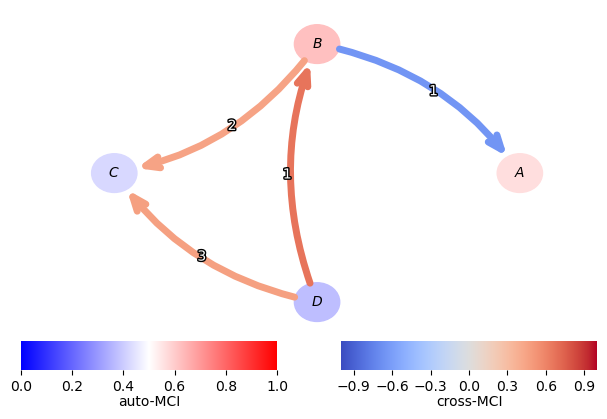

In [12]:
tp.plot_graph(
    val_matrix=results['val_matrix'],
    graph=graph,
    var_names=var_names,
    link_colorbar_label='cross-MCI',
    node_colorbar_label='auto-MCI',
    edge_ticks=0.3,
    cmap_edges='coolwarm',
    node_ticks=.2,
    cmap_nodes='bwr',
    ); 
plt.show()

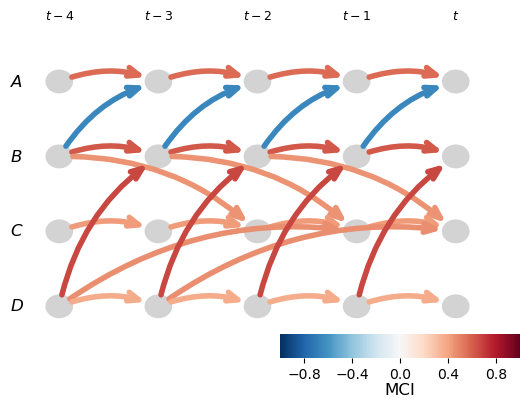

In [8]:
# Plot time series graph    
tp.plot_time_series_graph(
    figsize=(6, 4),
    val_matrix=results['val_matrix'],
    graph=graph,
    var_names=var_names,
    link_colorbar_label='MCI',
    ); plt.show()